# Семинар №1: математика в глубоком обучении

Имя, Фамилия:

In [2]:
import numpy as np
from typing import Callable
from functools import partial
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from IPython.display import HTML
from IPython.display import clear_output
%matplotlib inline
plt.rc('animation', html='html5')

## Задание 1: теория информации
Необходимо реализовать функции для расчета основных мер из теории информации: энтропии, KL-дивергенции и кросс-энтропии.



### 1.1 Энтропия (1 балл)

Формула энтропии для дискретного случая:

$$H(X) = -\sum_i p_i \log(p_i), \ \text{где} \ p_i = P(X_i)$$

In [3]:
def entropy(p: np.array) -> float:
    """
    Вычисляет энтропию для массива вероятностей.

    Args:
        p: Массив NumPy, представляющий распределение вероятностей.
           Значения в массиве должны быть неотрицательными.

    Returns:
        float: Значение энтропии.
    """

    # YOUR CODE
    mask = p > 0
    return -np.nansum(p[mask] * np.log(p[mask]))

Проверка корректноcти рассчета энтропии

In [4]:
assert np.allclose(entropy(np.array([0.1, 0.5, 0.1, 0.3])),
                  1.1682824501765625), "Что-то не так!"

assert np.allclose(entropy(np.array([0.0, 0.0, 1.0, 0.0])),
                  0.0), "Что-то не так!"

assert np.allclose(entropy(np.array([0.25, 0.25, 0.25, 0.25])),
                  1.3862943611198906), "Что-то не так!"

assert np.allclose(entropy(np.array([0.01, 0.99, np.nan, np.nan])),
                  0.056001534354847345), "Что-то не так!"

"Отлично!"

'Отлично!'

### 1.2 Расстояние Кульбака — Лейблера (1 балл)

Формула KL-дивергенции:

$$D_{KL}(P||Q)=\mathbb{E}_{x \sim P}\left[ \log \frac{p(x)}{q(x)}\right]$$

In [5]:
def kl_divergence(p: np.array, q: np.array) -> float:
    """
    Вычисляет расстояние Кульбака-Лейблера между двумя распределениями.

    Args:
        p: Массив NumPy, представляющий первое распределение.
        q: Массив NumPy, представляющий второе распределение.

    Returns:
        float: Значение KL-дивергенции.
    """

    return np.abs(np.nansum(p * np.log(p / q)))

Проверка корректноcти рассчета KL-дивергенции

In [6]:
assert np.allclose(kl_divergence(np.array([0.1, 0.2, 0.3, 0.4]),
                                 np.array([0.3, 0.2, 0.2, 0.3])),
                   0.1268511325463507), "Что-то не так!"

assert np.allclose(kl_divergence(np.array([0.5, np.nan]),
                                 np.array([0.75, np.nan])),
                   0.20273255405408222), "Что-то не так!"

assert np.allclose(kl_divergence(np.array([1.0, 0.0]),
                                 np.array([0.0, 1.0])),
                   float('inf')), "Что-то не так!"

assert np.allclose(kl_divergence(np.array([0.25, 0.25, 0.25, 0.25]),
                                 np.array([0.25, 0.25, 0.25, 0.25])),
                   0.0), "Что-то не так!"

"Отлично!"

<ipython-input-5-25868c5a41e3>:13: RuntimeWarning: divide by zero encountered in divide
  return np.abs(np.nansum(p * np.log(p / q)))
<ipython-input-5-25868c5a41e3>:13: RuntimeWarning: divide by zero encountered in log
  return np.abs(np.nansum(p * np.log(p / q)))
<ipython-input-5-25868c5a41e3>:13: RuntimeWarning: invalid value encountered in multiply
  return np.abs(np.nansum(p * np.log(p / q)))


'Отлично!'

### 1.2.1 Проверим свойства KL-дивергенции
Для проверки сгенерируем следующие распределения:
$$p \sim N(0,1)$$
$$q_1 \sim N(1,1)$$
$$q_2 \sim N(-1,1)$$



In [7]:
np.random.seed(1)
nd_len = 10000
p = np.random.normal(loc=0, scale=1, size=(nd_len, ))
q1 = np.random.normal(loc=-1, scale=1, size=(nd_len, ))
q2 = np.random.normal(loc=1, scale=1, size=(nd_len, ))

p = np.array(sorted(p))
q1 = np.array(sorted(q1))
q2 = np.array(sorted(q2))

Так как распределения $q_1$ и $q_2$ симметричны относительно оси $y$, то мы ожидаем, что $D_{KL}(p||q_1) \approx D_{KL}(p||q_2)$, убедимся в этом:

In [8]:
kl_pq1 = kl_divergence(p, q1)
kl_pq2 = kl_divergence(p, q2)
similar_percentage = abs(kl_pq1 - kl_pq2) / ((kl_pq1 + kl_pq2) / 2) * 100

kl_pq1, kl_pq2, similar_percentage

<ipython-input-5-25868c5a41e3>:13: RuntimeWarning: invalid value encountered in log
  return np.abs(np.nansum(p * np.log(p / q)))


(6067.781222631496, 6016.119246331953, 0.8550546478305254)

Как можно заметить, разница между ними менее 1%.

С другой стороны, посмотрим насколько отличаются между собой значения $D_{KL}(p||q_2)$ и $D_{KL}(q_2||p)$:

In [9]:
kl_q2p = kl_divergence(q2, p)
differ_percentage = abs(kl_q2p - kl_pq2) / ((kl_q2p + kl_pq2) / 2) * 100

kl_pq2, kl_q2p, differ_percentage

<ipython-input-5-25868c5a41e3>:13: RuntimeWarning: invalid value encountered in log
  return np.abs(np.nansum(p * np.log(p / q)))


(6016.119246331953, 9272.394118935521, 42.59766525110532)

Разница составляет около 40%. Таким образом, мы убедились в том, что:

$$D_{KL}(P||Q) \neq D_{KL}(Q||P)$$


## 1.3 Кросс-энтропия (1 балл)


Формула кросс-энтропии:

$$CE(P, Q) = - \ \mathbb{E}_{x \sim P}\left[ \log q(x) \right]$$

In [10]:
def cross_entropy(p: np.array, q: np.array) -> float:
    """
    Вычисляет кросс-энтропию между двумя дискретными распределениями.

    Args:
        p: Массив NumPy, представляющий первое распределение.
        q: Массив NumPy, представляющий второе распределение.

    Returns:
        float: Значение кросс-энтропии между распределениями p и q.
    """

    return - np.nansum(p * np.log(q))

Проверка корректноcти рассчета кросс-энтропии:

In [11]:
assert np.allclose(cross_entropy(np.array([0.25, 0.25, 0.25, 0.25]),
                                 np.array([0.1, 0.4, 0.1, 0.4])),
                   1.6094379124341003), "Что-то не так!"

assert np.allclose(cross_entropy(np.array([0.5, np.nan]),
                                 np.array([0.75, np.nan])),
                   0.14384103622589045), "Что-то не так!"

assert np.allclose(cross_entropy(np.array([0.25, 0.25, 0.25, 0.25]),
                                 np.array([0.25, 0.25, 0.25, 0.25])),
                   1.3862943611198906), "Что-то не так!"

"Отлично!"

'Отлично!'

## 1.4 Проверим связь трех мер:

$$CE(P, Q) = H(P) + D_{KL}(P||Q) $$

In [12]:
p = np.array([0.1, 0.4, 0.5])
q = np.array([0.2, 0.3, 0.5])

left_part = cross_entropy(p, q)
right_part = entropy(p) + kl_divergence(p, q)
left_part, right_part, abs(left_part-right_part)

(0.9891065032537572, 0.9891065032537573, 1.1102230246251565e-16)

## Задание 2: дифференцирование (1 балл)


Найти аппроксимацию функции $f(x,y) = \log (e^x + e^y)$ в точке $f(\varepsilon_1, \log(2)+ \varepsilon_2)$


In [13]:
def f(x: float, y: float) -> float:
    """
    Вычисляет значение функции f в точке (x, y)
    """

    return np.log(np.exp(x) + np.exp(y))


def grad_f(x: float, y: float) -> float:
    """
    Вычисляет значение градиента функции f в точке (x, y)
    """

    return np.array([np.exp(x) / (np.exp(x) + np.exp(y)), np.exp(y) / (np.exp(x) + np.exp(y))])

def get_true_value(f: Callable, epsilon: np.array) -> float:
    """
    Вычисляет "истинное" значение функции f(x, y) в точке,
    смещенной на вектор epsilon.

    Args:
        f: Функция двух переменных (x, y), для которой вычисляется значение.
        epsilon: Массив NumPy размерности (2,), представляющий смещение.

    Returns:
        float: Значение функции f(x, y) в точке, смещенной на вектор epsilon.
    """

    return f(0 + epsilon[0], np.log(2) + epsilon[1])

def get_approximation(f: Callable, grad_f: Callable, epsilon: np.array) -> float:
    """
    Вычисляет приближенное значение функции f(x, y) в точке,
    смещенной на вектор epsilon, используя линейную аппроксимацию.

    Args:
        f: Функция двух переменных (x, y), для которой вычисляется значение.
        grad_f: Функция, возвращающая градиент f(x, y).
        epsilon: Массив NumPy размерности (2,), представляющий смещение.

    Returns:
        float: Приближенное значение функции f(x, y) в точке, полученное
        с помощью линейной аппроксимации.
    """

    return f(0, np.log(2)) + np.sum(epsilon * grad_f(0, np.log(2)))

Проверка полученной аппроксимации:

In [14]:
np.random.seed(2)
epsilon = np.random.normal(loc=0, scale=1, size=2)

assert np.allclose(get_true_value(f, epsilon),
                   get_approximation(f, grad_f, epsilon),
                   rtol=2.0e-2), "Что-то не так!"

get_true_value(f, epsilon), get_approximation(f, grad_f, epsilon)

(0.9359969901415748, 0.9221817880487333)

# Задание 3: Методы оптимизации (6 баллов)

В этом задании необходимо реализовать и сравнить между собой различные методы оптимизации. Для всех экспериментов **подберите параметры** так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [15]:
# Код для анимации, источник:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))
        self.fig = plt.figure(figsize=(10, 10))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

Генерируем данные:

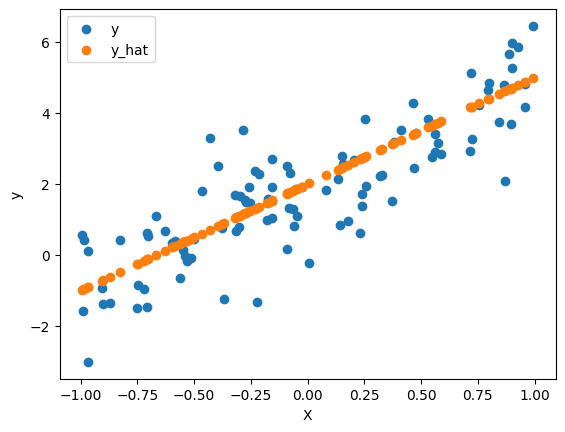

In [16]:
size = 100

# Создаем тензор X размера (size, 2) заполненный единицами.
X = torch.ones(size, 2)

# Заполняем первый столбец X случайными числами равномерно распределенными от -1 до 1.
X[:, 0].uniform_(-1., 1)

# Создаем целевые значения y_hat как линейную комбинацию X[:, 0] (фактор 3) + 2.
y_hat = 3 * X[:, 0] + 2

# Создаем истинные значения y, добавив случайный шум к y_hat.
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Посмотрим на ландшафт различных функций ошибок:

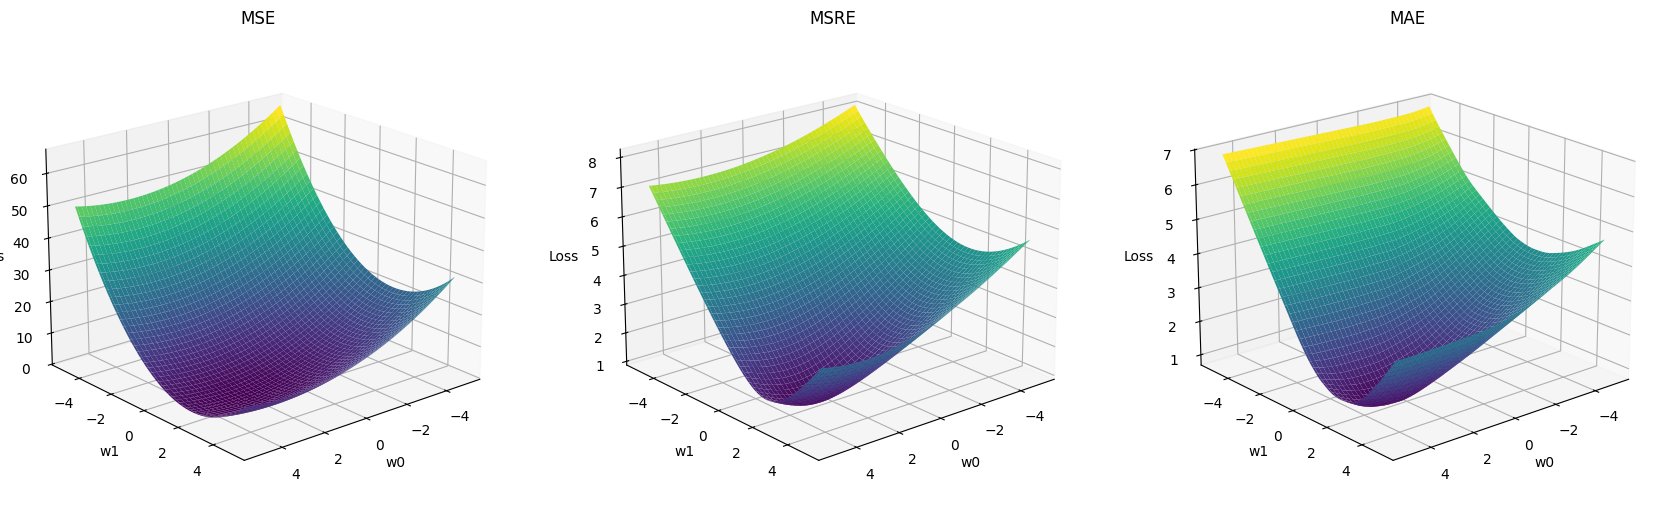

In [17]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

Базовый класс оптимизаторов:

In [18]:
class Optimizer:
    """
    Базовый класс для оптимизаторов.

    Attributes:
        params (list): Список параметров модели,
        которые необходимо оптимизировать.

    Notes:
        Этот класс является абстрактным и не должен использоваться напрямую.
        Он предназначен для создания конкретных оптимизаторов, которые
        наследуются от него и реализуют необходимые методы.
    """

    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        """
        Обнуляет градиенты всех параметров.

        Это важно делать перед каждым новым шагом оптимизации,
        так как PyTorch накапливает градиенты по умолчанию.
        """

        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        """
        Метод для выполнения каких-либо действий перед шагом оптимизации.
        """
        pass

    def step(self):
        """
        Метод для выполнения шага оптимизации.
        """
        pass

    def update_param(self, p):
        """
        Абстрактный метод для обновления отдельного параметра.
        """
        raise NotImplementedError()

Функции для оптимизации и сравнения оптимизаторов:

In [19]:
def optimize_function(fn: Callable,
                      optim: Optimizer,
                      optim_args: dict,
                      start_point,
                      num_iter = 50):
    """
    Оптимизирует функцию с помощью заданного алгоритма оптимизации.

    Args:
        fn (Callable): Функция, которую необходимо минимизировать. Принимает тензор весов
            и возвращает тензор потерь.
        optim (Optimizer): Класс оптимизатора, например, SGD.
        optim_args (dict): Словарь аргументов для конструктора оптимизатора.
            Например, {'lr': 0.01} для скорости обучения.
        start_point (list): Начальная точка для оптимизации.
        num_iter (int): Количество итераций оптимизации.

    Returns:
        tuple: Кортеж, содержащий:
            points (torch.Tensor): Тензор, содержащий историю изменения весов на каждой итерации,
              размерности (num_iter, *shape_of_start_point)
            losses (torch.Tensor): Тензор, содержащий историю значений потерь на каждой итерации,
              размерности (num_iter).
    """
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points, losses = [], []

    for i in range(num_iter):

        if hasattr(optim, 'pre_step'):
            optim.pre_step()

        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())

        loss.backward()
        optim.step()
        optim.zero_grad()

    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)

    return points, losses

In [20]:
def compare_optimizers(loss_animator: LossAnimator,
                       fn: Callable,
                       optim_list: list,
                       start_point: list,
                       num_iter = 50,
                       step_skip = 1):
    """
    Сравнивает производительность нескольких алгоритмов оптимизации
    при минимизации заданной функции.

    Args:
        loss_animator (LossAnimator): Экземпляр LossAnimator,
        используемый для анимации процесса обучения.
        fn (Callable): Функция потерь, которую необходимо минимизировать.
        optim_list (list): Список кортежей, содержащих информацию о каждом оптимизаторе.
            Каждый кортеж должен иметь вид (name, optim, args), где:
                name (str): Имя оптимизатора.
                optim (type): Класс оптимизатора (например, SGD).
                args (dict): Словарь аргументов для конструктора оптимизатора.
        start_point (list): Начальная точка для оптимизации.
        num_iter (int): Количество итераций оптимизации.
        step_skip (int): Шаг пропуска при отрисовке кадров анимации.

    Returns:
        matplotlib.animation.FuncAnimation: Объект анимации Matplotlib.
    """

    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)

    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim,
                                           args, start_point, num_iter)
        data[name] = {'weights': points, 'losses': losses}

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализуйте метод градиентного спуска (1 балл):

$$\theta_t = \theta_{t-1} - \eta \sum_{i_1, ..., i_k} \nabla_{\theta} J_i(\theta_{t_1}) $$

In [21]:
class SGD(Optimizer):
    """
    Реализация стохастического градиентного спуска.

    Attributes:
        lr (float): Скорость обучения, которая определяет величину
            шага обновления параметров.
    """
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr
        self.params = params

    def step(self):
        """
        Шаг оптимизатора.
        """
        for param in self.params:
            param.data -= self.lr * param.grad.data

In [22]:
#compare_optimizers(loss_animator, mse, [('SGD', SGD, {'lr': 1.5e-1})], start_point=[-20, -20], num_iter=100, step_skip = 10)

# Домашнее задание № 1
Реализовать методы оптимизации (*Momentum, NAG, Adagrad, Adadelta, Adam*), сравнить их между собой на предложенном примере и **написать вывод текстом**.

За каждый реализованный метод оптимизации - 1 балл.

ВАЖНО: баллы за методы оптимизации начисляются только в случае подбора параметров для каждого из них, а также наличия сравнения методов между собой и текстового вывода.

+ Мягкий дедлайн: `30.01.25 23:59`
+ Жесткий дедлайн: `06.02.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.

In [23]:
class Momentum(Optimizer):
    """
    Реализация стохастического градиентного спуска + момент.

    Attributes:
        lr (float): Скорость обучения, которая определяет величину
            шага обновления параметров.
    """
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.params = params
        self.ema = [torch.zeros(param.data.shape) for param in params]
        self.gamma = gamma

    def step(self):
        """
        Шаг оптимизатора.
        """
        for i, param in enumerate(self.params):
            self.ema[i] = self.ema[i] * self.gamma + self.lr * param.grad.data
            param.data -= self.ema[i]

In [24]:
class NAG(Optimizer):
    """
    Реализация NAG.

    Attributes:
        lr (float): Скорость обучения, которая определяет величину
            шага обновления параметров.
    """
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.params = params
        self.ema = [torch.zeros(param.data.shape) for param in params]
        self.gamma = gamma

    def pre_step(self):
        """
        Метод для выполнения каких-либо действий перед шагом оптимизации.
        """
        for i, param in enumerate(self.params):
            param.data -= self.gamma * self.ema[i]

    def step(self):
        """
        Шаг оптимизатора.
        """
        for i, param in enumerate(self.params):
            param.data += self.gamma * self.ema[i]
            self.ema[i] = self.gamma * self.ema[i] + self.lr * param.grad.data
            param.data -= self.ema[i]

In [25]:
class Adagrad(Optimizer):
    """
    Реализация Adagrad: запоминание суммы квадратов всех градиентов до этого момента, для каждого параметра.

    Attributes:
        lr (float): Скорость обучения, которая определяет величину
            шага обновления параметров.
    """
    def __init__(self, params, eta=0.01, eps=1e-8):
        super().__init__(params)
        self.eta = eta
        self.eps = eps
        self.params = params
        self.G = [torch.zeros(param.data.shape) for param in params]

    def step(self):
        """
        Шаг оптимизатора.
        """
        for i, param in enumerate(self.params):
            grad = param.grad.data
            self.G[i] += grad ** 2
            param.data -= self.eta * grad / torch.sqrt(self.G[i] + self.eps)

In [26]:
class RMSProp(Optimizer):
    """
    Реализация RMSProp: Adagrad с обновлением не на сумму квадратов градиентов, а на их скользящее среднее.

    Attributes:
        lr (float): Скорость обучения, которая определяет величину
            шага обновления параметров.
    """
    def __init__(self, params, gamma=0.9, eta=0.01, eps=1e-8):
        super().__init__(params)
        self.eta = eta
        self.eps = eps
        self.gamma = gamma
        self.params = params
        self.G = [torch.zeros(param.data.shape) for param in params]

    def step(self):
        """
        Шаг оптимизатора.
        """
        for i, param in enumerate(self.params):
            grad = param.grad.data
            self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * grad ** 2
            param.data -= self.eta * grad / torch.sqrt(self.G[i] + self.eps)

In [27]:
class Adadelta(Optimizer):
    """
    Реализация Adadelta: RMSProp + избавимся от learning rate.

    Attributes:
        lr (float): Скорость обучения, которая определяет величину
            шага обновления параметров.
    """
    def __init__(self, params, gamma=0.9, eps=1e-8):
        super().__init__(params)
        self.eps = eps
        self.gamma = gamma
        self.params = params
        self.G = [torch.zeros(param.data.shape) for param in params]
        self.P = [torch.zeros(param.data.shape) for param in params]

    def step(self):
        """
        Шаг оптимизатора.
        """
        for i, param in enumerate(self.params):
            grad = param.grad.data
            self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * grad ** 2
            dp = torch.sqrt(self.P[i] + self.eps) * grad / torch.sqrt(self.G[i] + self.eps)
            param.data -= dp
            self.P[i] = self.gamma * self.P[i] + (1 - self.gamma) * dp ** 2

In [ ]:
class Adam(Optimizer):
    """
    Реализация Adam: объединим лучшие идеи: импульс и адаптивный шаг.

    Attributes:
        lr (float): Скорость обучения, которая определяет величину
            шага обновления параметров.
    """
    def __init__(self, params, eta=0.01, beta_1=0.9, beta_2=0.99, eps=1e-8):
        super().__init__(params)
        self.eps = eps
        self.eta = eta
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.params = params
        self.M = [torch.zeros(param.data.shape) for param in params]
        self.V = [torch.zeros(param.data.shape) for param in params]
        self.t = 0

    def step(self):
        """
        Шаг оптимизатора.
        """
        self.t += 1
        for i, param in enumerate(self.params):
            grad = param.grad.data
            self.M[i] = self.beta_1 * self.M[i] + (1 - self.beta_1) * grad
            self.V[i] = self.beta_2 * self.V[i] + (1 - self.beta_2) * grad ** 2
            m = self.M[i] / (1 - self.beta_1 ** self.t)
            v = self.V[i] / (1 - self.beta_2 ** self.t)
            param.data -= self.eta * m / (torch.sqrt(v) + self.eps)

#### Сравнение параметров для метода оптимизации Momentum:

In [ ]:
compare_optimizers(loss_animator, mse, [('0.9, 0.01', Momentum, {'gamma': 0.9, 'lr': 0.01}), ('0.95, 0.01', Momentum, {'gamma': 0.95, 'lr': 0.01}), \
                                        ('0.9, 0.1', Momentum, {'gamma': 0.9, 'lr': 0.1}), ('0.95, 0.1', Momentum, {'gamma': 0.95, 'lr': 0.1})], \
                   start_point=[-20, -20], num_iter=100, step_skip = 10)

#### Сравнение параметров для метода оптимизации NAG:

In [28]:
compare_optimizers(loss_animator, mse, [('0.9, 0.01', NAG, {'gamma': 0.9, 'lr': 0.01}), ('0.95, 0.01', NAG, {'gamma': 0.95, 'lr': 0.01}), \
                                        ('0.9, 0.1', NAG, {'gamma': 0.9, 'lr': 0.1}), ('0.95, 0.1', NAG, {'gamma': 0.95, 'lr': 0.1})], \
                   start_point=[-20, -20], num_iter=100, step_skip = 10)

#### Сравнение параметров для метода оптимизации Adagrad:

In [ ]:
compare_optimizers(loss_animator, mse, [('1e-8, 0.1', Adagrad, {'eps': 1e-8, 'eta': 0.1}), ('1e-6, 0.1', Adagrad, {'eps': 1e-6, 'eta': 0.1}), \
                                        ('1e-8, 1', Adagrad, {'eps': 1e-8, 'eta': 1}), ('1e-6, 1', Adagrad, {'eps': 1e-6, 'eta': 1})], \
                   start_point=[-20, -20], num_iter=10000, step_skip = 100)

#### Сравнение параметров для метода оптимизации Adadelta:

In [ ]:
compare_optimizers(loss_animator, mse, [('1e-8, 0.9', Adadelta, {'eps': 1e-8, 'gamma': 0.9}), ('1e-6, 0.9', Adadelta, {'eps': 1e-6, 'gamma': 0.9}), \
                                        ('1e-8, 0.95', Adadelta, {'eps': 1e-8, 'gamma': 0.95}), ('1e-6, 0.95', Adadelta, {'eps': 1e-6, 'gamma': 0.95})], \
                   start_point=[-20, -20], num_iter=3000, step_skip = 100)

In [ ]:
compare_optimizers(loss_animator, mse, [('1e-6, 0.9', Adadelta, {'eps': 1e-6, 'gamma': 0.9}), ('1e-5, 0.9', Adadelta, {'eps': 1e-5, 'gamma': 0.9}), \
                                        ('1e-4, 0.9', Adadelta, {'eps': 1e-4, 'gamma': 0.9})], \
                   start_point=[-20, -20], num_iter=3000, step_skip = 100)

#### Сравнение параметров для метода оптимизации Adam:

In [ ]:
compare_optimizers(loss_animator, mse, [('0.1, 1e-8', Adam, {'beta_1': 0.9, 'beta_2': 0.99, 'eta': 0.1, 'eps': 1e-8}), ('1, 1e-8', Adam, {'beta_1': 0.9, 'beta_2': 0.99, 'eta': 1, 'eps': 1e-8}), \
                                        ('10, 1e-6', Adam, {'beta_1': 0.9, 'beta_2': 0.99, 'eta': 10, 'eps': 1e-6}), ('0.01, 1e-6', Adam, {'beta_1': 0.9, 'beta_2': 0.99, 'eta': 0.01, 'eps': 1e-6})], \
                   start_point=[-20, -20], num_iter=100, step_skip = 5)

#### Сравнение разных методов оптимизации:

Сравнение методов оптимизации Momentum и NAG при равных параметрах. Можно заметить, что функция loss для NAG уменьшается быстрее, но сама функция более плавно меняется.

In [50]:
compare_optimizers(loss_animator, mse, [('NAG', NAG, {'gamma': 0.9, 'lr': 0.01}), ('Momentum', Momentum, {'gamma': 0.9, 'lr': 0.01})], \
                   start_point=[-20, -20], num_iter=100, step_skip = 10)

Сравнение методов оптимизации RMSProp и его версии без learning rate - Adadelta при параметрах для RMSProp: $\gamma=0.9,\, \varepsilon=1e-8$, для Adadelta: $\gamma=0.9,\, \varepsilon=1e-6$. Для Adadelta нужно большее число итераций, поэтому взято большее значение для $\varepsilon$, чтобы самые первые шаги градиента не были слишком маленькими.

In [46]:
compare_optimizers(loss_animator, mse, [('RMSProp', RMSProp, {'gamma': 0.9, 'eta': 0.01, 'eps': 1e-8}), ('Adadelta', Adadelta, {'gamma': 0.9, 'eps': 1e-6})], start_point=[-20, -20], num_iter=5000, step_skip = 100)

Сравнение методов оптимизации Adagrad и его версии со скользящим средним для квадрата градиента - RMSProp при параметрах для RMSProp: $\gamma=0.9,\, \varepsilon=1e-8, \, \eta=0.01$, для Adagrad: $\eta=0.01,\, \varepsilon=1e-8$. Можно заметить, RMSProp работает быстрее, это соотносится с тем, что этот метод решает проблему затухания изменений.

In [47]:
compare_optimizers(loss_animator, mse, [('RMSProp', RMSProp, {'gamma': 0.9, 'eta': 0.01, 'eps': 1e-8}), ('Adagrad', Adagrad, {'eta': 0.01, 'eps': 1e-8})], start_point=[-20, -20], num_iter=10000, step_skip = 100)

Сравнение методов оптимизации Adam и Adadelta при их стандартных значениях параметров. Для Adam: $\beta_1=0.9,\, \beta_2=0.99, \, \varepsilon=1e-8, \, \eta=0.01$, для Adadelta: $\gamma=0.9,\, \varepsilon=1e-6$.

In [48]:
compare_optimizers(loss_animator, mse, [('Adam', Adam, {'beta_1': 0.9, 'beta_2': 0.99, 'eta': 0.01, 'eps': 1e-8}), ('Adadelta', Adadelta, {'gamma': 0.9, 'eps': 1e-6})], start_point=[-20, -20], num_iter=5000, step_skip = 100)

##### Сравнение методов с их стандартными параметрами, за исключением learning rate = 0.1, а не 0.01, так как для Adagrad и Adadelta нужно очень большое число итераций при learning rate = 0.01, чтоб увидеть процесс обучения алгоритмов. Быстрее всех уменьшается loss у метода Momentum, но остальные алгоритмы более плавно подходят к точке минимума. При использовании Adam, loss сходится плавно и при этом быстро. Ожидаемо, что loss сходится медленнее при использовании Adadelta, так как изначально изменение параметров происходит очень маленькими шагами.

In [ ]:
compare_optimizers(loss_animator, mse, [('Momentum: gamma=0.9, lr=0.1', Momentum, {'gamma': 0.9, 'lr': 0.1}), \
                                        ('Adagrad: eps=1e-8, lr=0.1', Adagrad, {'eps': 1e-8, 'eta': 0.1}), \
                                        ('Adadelta: gamma=0.9, eps=1e-8', Adadelta, {'gamma': 0.9, 'eps': 1e-8}), \
                                        ('Adam: beta_1=0.9, beta_2=0.99, lr=0.1, eps=1e-8', Adam, {'beta_1': 0.9, 'beta_2': 0.99, 'eta': 0.1, 'eps': 1e-8})],
                   start_point=[-20, -20], num_iter=100, step_skip = 10)

<ipython-input-14-6017a73346e6>:115: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return HTML(anim.to_html5_video())
